# 377개의 컬럼
- PCA주성분분석
- RandomForest 모델링
- 라벨링 임계치는 0.01, 상위 10%이내, 상위5%이내

# 공통 모듈 임포트

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 가져오기
- 결측치제거, 상관관계0.9이상, 분산이 0인 컬럼 제거후 left, right, ceter관련 피처와 레이블 컬럼이 포함된 377개의 컬럼

In [ ]:
# working_dir = './data/'
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/7회차_Graphviz/data/'
fact_init_data = pd.read_csv(working_dir + 'fact_data_lr_result.csv',index_col='dat...date.name.')
fact_init_data

# 피처 저장
- 레이블(4개)을 제외한 373개 피처를 변수에 저장

In [ ]:
X_data = fact_init_data.iloc[:,:-4]
y_data = fact_init_data.iloc[:,-4:]

# 373개 컬럼에 대한 PCA주성분 분석

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X_data)
pca = PCA()
pca.fit(df_scaled)
X_data_pca = pca.transform(df_scaled)

# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(X_data.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.554557e+00,3.163414e-01,0.316341
pca2,1.203831e+00,1.490754e-01,0.465417
pca3,7.758459e-01,9.607624e-02,0.561493
pca4,4.373274e-01,5.415608e-02,0.615649
pca5,3.400667e-01,4.211187e-02,0.657761
...,...,...,...
pca369,4.572814e-22,5.662707e-23,1.000000
pca370,4.354103e-22,5.391867e-23,1.000000
pca371,2.494828e-22,3.089450e-23,1.000000
pca372,1.487501e-22,1.842034e-23,1.000000


## 누적기여율 0.9이상의 컬럼개수 - 24개

In [ ]:
print(len(result[result['누적기여율'] < 0.9]))

24


## Elbow(그래프가 급격히 꺾이는 지점) 확인
- n_components = 7, 주성분 7개로 전체 데이터를 설명할 수 있을 것으로 보임

Text(0, 0.5, 'explained_variance_ratio_')

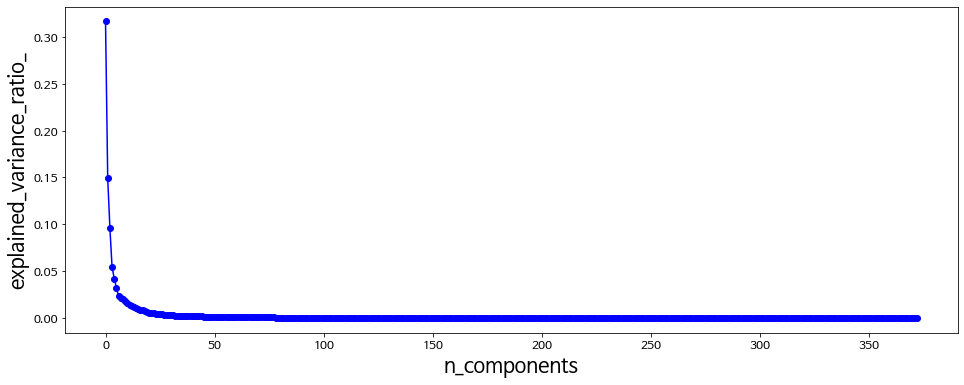

In [ ]:
# 방법1 이용함
# Scree Plot 그리기
# x축 : n_components 수
# y축 : 설명변수
plt.figure(figsize=(16, 6))
plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
plt.xlabel("n_components", fontsize=20)
plt.ylabel("explained_variance_ratio_", fontsize=20)

# PCA : n_component2개 설정

In [ ]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca_2 = pca.transform(df_scaled)
print(df_pca_2.shape)
new_df_pca_2 =  pd.DataFrame(data=df_pca_2, columns=['PC1','PC2'], index=X_data.index)
new_df_pca_2

(8145, 2)


,PC1,PC2
dat...date.name.,,
2016-01-01 07,3.577244,1.464186
2016-01-01 08,3.561934,1.448741
2016-01-01 09,3.588629,1.464363
2016-01-01 10,3.593467,1.474499
2016-01-01 11,3.653216,1.488370
...,...,...
2016-12-31 19,-0.555484,2.408034
2016-12-31 20,-0.534497,2.440881
2016-12-31 21,-0.500515,2.415586


## PC1과 PC2와의 관계

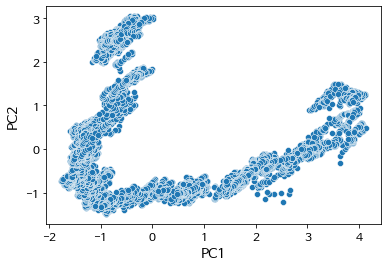

In [ ]:
sns.scatterplot(x=new_df_pca_2.iloc[:,0], y=new_df_pca_2.iloc[:,1])

# 함수

## 양품과 불량품의 비율 그래프를 생성하는 함수

In [ ]:
def show_labels_cnt(y_df):
    rows = 2
    cols = 2
    # constrained_layout : 플롯간의 간격을 자동으로 조절
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(10,8))
    for i in range(len(y_df.columns)):
        # 양품의 개수
        good_RD = y_df.iloc[:,i].value_counts()[0]
        # 불량품의 개수
        bad_RD = y_df.iloc[:,i].value_counts()[1]
        # 카운트 그래프
        a = sns.countplot(x=y_df.columns[i], data=y_df, ax=ax[i//2, i%2])
        cnt = 0
        for p in a.patches:
            height = p.get_height() # 그래프의 높이(개수를 그래프위에 표시하기 위해 필요)
            # 개수를 그래프에 표시
            a.text(p.get_x()+p.get_width()/2., height + 0.1, y_df.iloc[:,i].value_counts()[cnt],ha="center")
            cnt += 1
    plt.show()

## 분류에서의 평가지표를 출력해주는 함수

In [ ]:
## 분류에서의 평가지표를 출력해주는 함수
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('정확도:', accuracy)
    print('정밀도:', precision)
    print('재현율:', recall)
    print('F1:', f1)
    print('AUC:', roc_auc)

##   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프를 보여주는 함수

In [ ]:
def show_feature_label(ft_top24, y_df):
    y_df = y_df.set_index(X_data.index)
    rows = 1
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    cnt=0
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

# 모듈 임포트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

# 임계치 : 상위 5%

## 레이블 라벨링

In [ ]:
quartile_5p = y_data.quantile(q=0.95)

print('<각 컬럼의 상위 5% 임계점>\n',quartile_5p)
y_data_labels_5p = pd.DataFrame(np.where(y_data > quartile_5p, 1, 0), columns = y_data.columns)
y_data_labels_5p.head()

<각 컬럼의 상위 5% 임계점>
 L.RD     0.063
L.Vac    0.082
R.RD     0.099
R.Vac    0.037
Name: 0.95, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,0,1,1
1,0,0,1,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 상위 5% 설정의 경우, 카운트 그래프

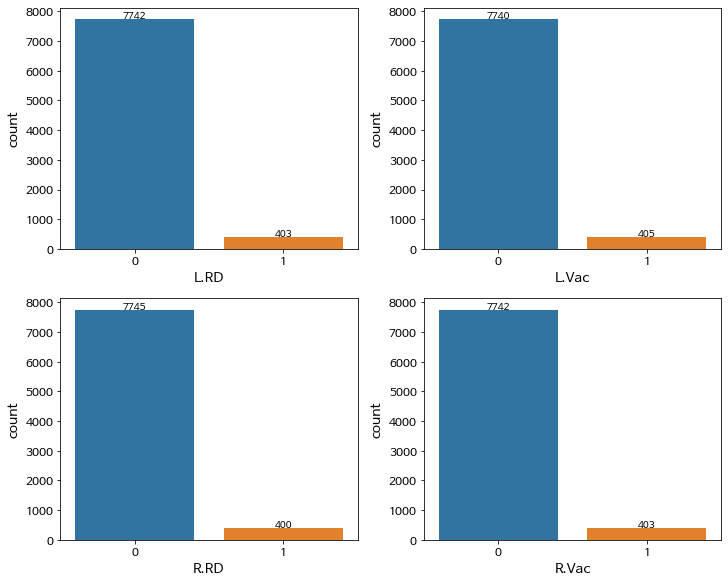

In [ ]:
show_labels_cnt(y_data_labels_5p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
all_data_5p_LRD = pd.concat([X_data, y_data_labels_5p.iloc[:,0]], axis=1)

X_train_5p, X_test_5p, y_train_5p, y_test_5p = train_test_split(X_data, y_data_labels_5p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_5p.shape)
print(y_test_5p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_5p.value_counts()/y_train_5p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_5p.value_counts()/y_test_5p.count())

(6516,)
(1629,)
0    0.95043
1    0.04957
Name: L.RD, dtype: float64
0    0.95089
1    0.04911
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
print(X_train_5p.shape)
print(y_train_5p.shape)

(6516, 373)
(6516,)


In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9625537139349294
정밀도: 0.7111111111111111
재현율: 0.4
F1: 0.512
AUC: 0.9094899935442221


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.024394
D_AB7_L_UL                             0.010324
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.009284
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.009037
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.008672
N2.TO.EA1315B.1FI33528A_PV             0.007586
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.007492
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.007325
D_AB8_U_LR                             0.007195
N2.TO.EA1313B.1FI33527A_PV             0.007159
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.007112
ROOF.HEATING.Zone80.1JIC31180.PV       0.007108
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.007057
D_AB8_L_UL                             0.006873
S_AB1_AB11_L                           0.006733
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.006649
ROOF.HEATING.Zone11.1JIC31111.PV       0.006418
D_AB3_R_UL                             0.006403
D_AB4_L_LR                             0.005876
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.005864
D_AB6_U_LR                             0

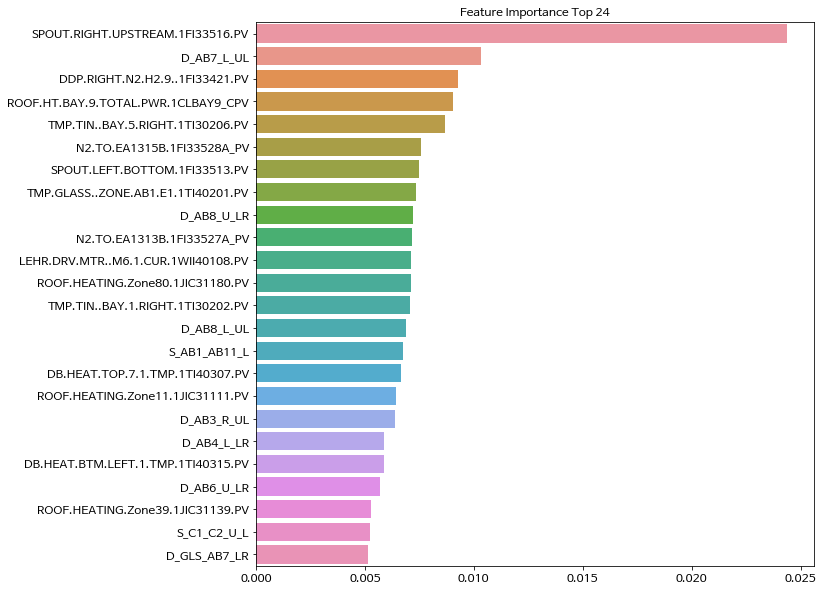

In [ ]:
ft_importance_values_5p = rf_clf_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='1_randomForest_LRD_5p_2.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_5p_2.dot', '-o', working_dir + '1_randomForest_LRD_5p_2.png', '-Gdpi=600'])


0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

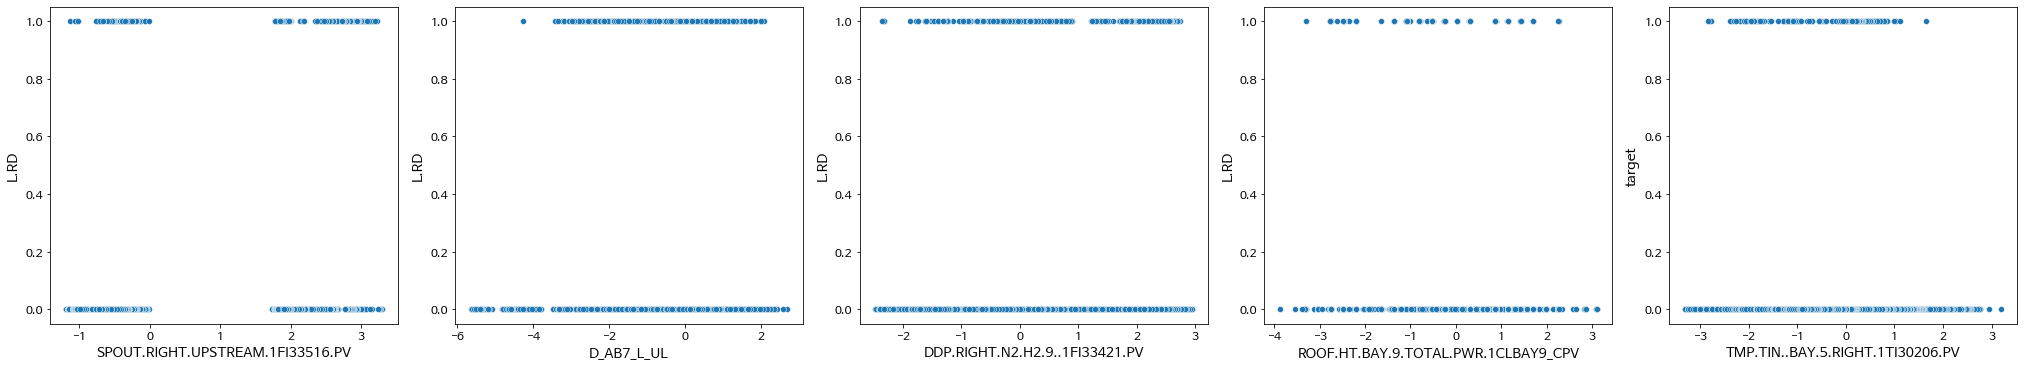

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

## 하이퍼파라미터 튜닝

In [ ]:
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 17, 19, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50, 100, 130]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_5 = GridSearchCV(rf_clf_5p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_5.fit(X_train_5p, y_train_5p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_5p = gridcv_5.best_estimator_
# print(rf_estimator_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_estimator_5p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_5p.fit(X_train_5p, y_train_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_predict_5p = rf_estimator_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_estimator_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.958256599140577
정밀도: 0.6875
재현율: 0.275
F1: 0.3928571428571429
AUC: 0.9164985474499676


### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.034749
D_AB7_L_UL                             0.028896
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.019026
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.015888
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.013820
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.012364
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.011779
DB.BTM.DN.STM.TC.LC.1TI40405_PV        0.010658
D_AB3_R_UL                             0.010589
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.009651
S_C1_C2_U_L                            0.009490
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.008896
S_AB11_C1_U_L                          0.008793
ATM.N2.H2.5..함유율.1CLFI33402_CPV        0.008763
D_AB8_U_LR                             0.008699
ROOF.HEATING.Zone41.1JIC31141.PV       0.008641
D_C1_R_UL                              0.008593
D_AB8_L_LR                             0.008525
N2.TO.EA1315B.1FI33528A_PV             0.008173
D_AB4_L_LR                             0.007572
ROOF.HEATING.Zone80.1JIC31180.PV       0

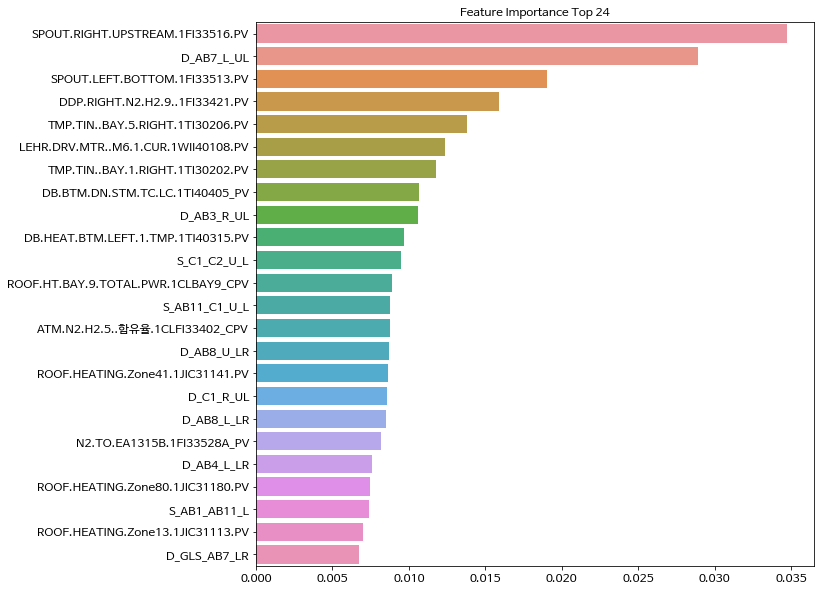

In [ ]:
ft_importance_values_5p = rf_estimator_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_estimator_5p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_5p.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_5p.dot', '-o', working_dir + '2_randomForest_LRD_5p.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

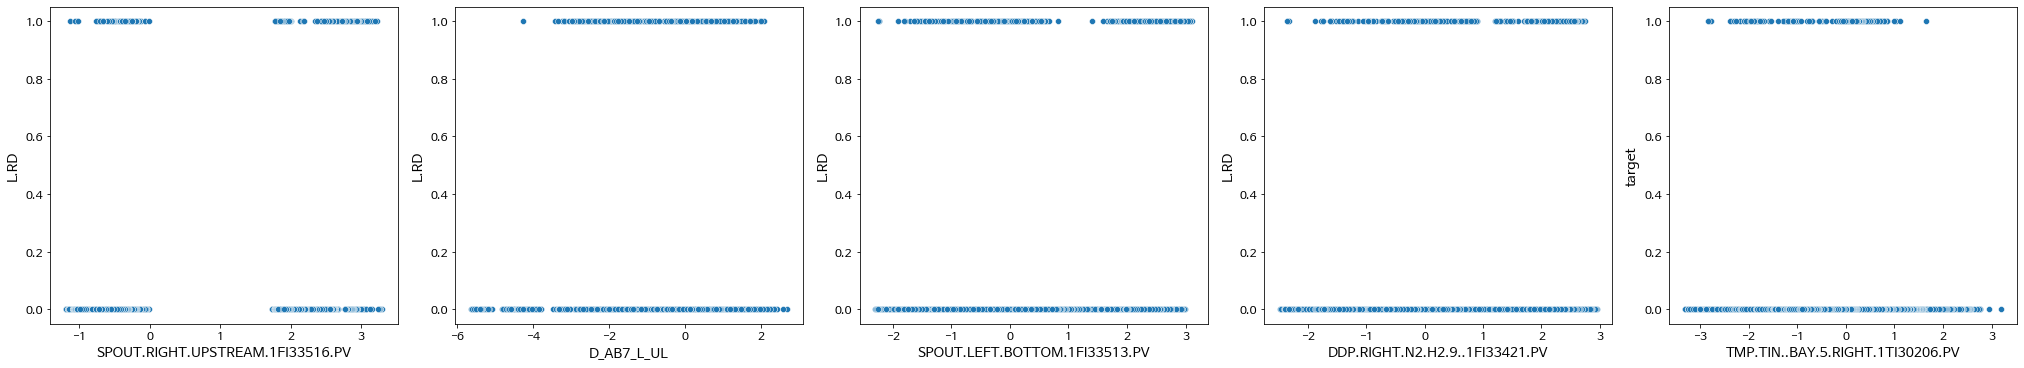

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

# 임계치 : 상위 10%
## 레이블 라벨링

In [ ]:
quartile_10p = y_data.quantile(q=0.9)

print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
y_data_labels_10p = pd.DataFrame(np.where(y_data > quartile_10p, 1, 0), columns = y_data.columns)
y_data_labels_10p.head()

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


,L.RD,L.Vac,R.RD,R.Vac
0,0,1,1,1
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [ ]:
origin_y_data = y_data.copy()
y_data_labels_10p = y_data.copy()

quartile_10p = origin_y_data.quantile(q=0.9)
print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
for i in range(len(origin_y_data.columns)) : 
    column_name = origin_y_data.columns[i]

    # 양품 데이터 설정
    y_data_labels_10p[column_name] = 0
    condition = (origin_y_data[column_name] > quartile_10p[i])
    # 불량품 레이블 데이터 설정
    y_data_labels_10p[column_name][condition] = 1

<각 컬럼의 상위 10% 임계점>
 L.RD     0.040
L.Vac    0.050
R.RD     0.066
R.Vac    0.026
Name: 0.9, dtype: float64


### 임계치가 상위 10% 설정의 경우, 카운트 그래프

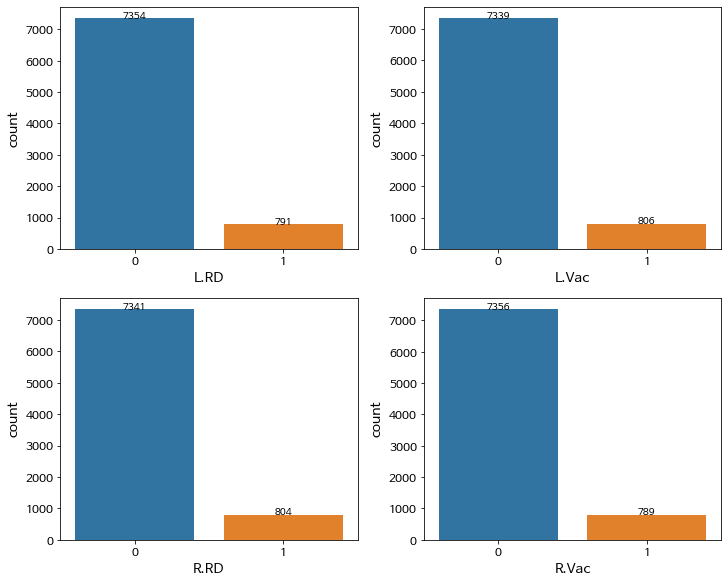

In [ ]:
show_labels_cnt(y_data_labels_10p)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_10p, X_test_10p, y_train_10p, y_test_10p = train_test_split(X_data, y_data_labels_10p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_10p.shape)
print(y_test_10p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_10p.value_counts() / y_train_10p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_10p.value_counts() / y_test_10p.count())

(6516,)
(1629,)
0    0.902701
1    0.097299
Name: L.RD, dtype: float64
0    0.903622
1    0.096378
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_10p = RandomForestClassifier(random_state=42)
rf_clf_10p.fit(X_train_10p, y_train_10p)
rf_predict_10p = rf_clf_10p.predict(X_test_10p)
rf_predict_proba_10p = rf_clf_10p.predict_proba(X_test_10p)[:,1]
get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

정확도: 0.9244935543278084
정밀도: 0.7125
재현율: 0.3630573248407643
F1: 0.4810126582278481
AUC: 0.8597622715314318


### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.017033
D_AB7_L_UL                             0.009193
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.008417
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.008371
S_AB10_AB11_L_L                        0.007469
N2.TO.EA1315B.1FI33528A_PV             0.007309
S_AB11_C1_U_L                          0.007244
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.006504
N2.TO.EA1313B.1FI33527A_PV             0.006498
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.006398
D_AB3_R_UL                             0.006297
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.006037
ROOF.HEATING.Zone11.1JIC31111.PV       0.005840
LOWER.C1..Z168.TMP.1TIC42257.PV        0.005612
D_AB6_U_LR                             0.005482
D_C1_L_UL                              0.005398
cluster                                0.005276
ROOF.HEATING.Zone27.1JIC31127.PV       0.005260
DB.BTM.DN.STM.TC.RC.1TI40407_PV        0.005259
D_C1_R_UL                              0.005210
D_AB7_L_LR                             0

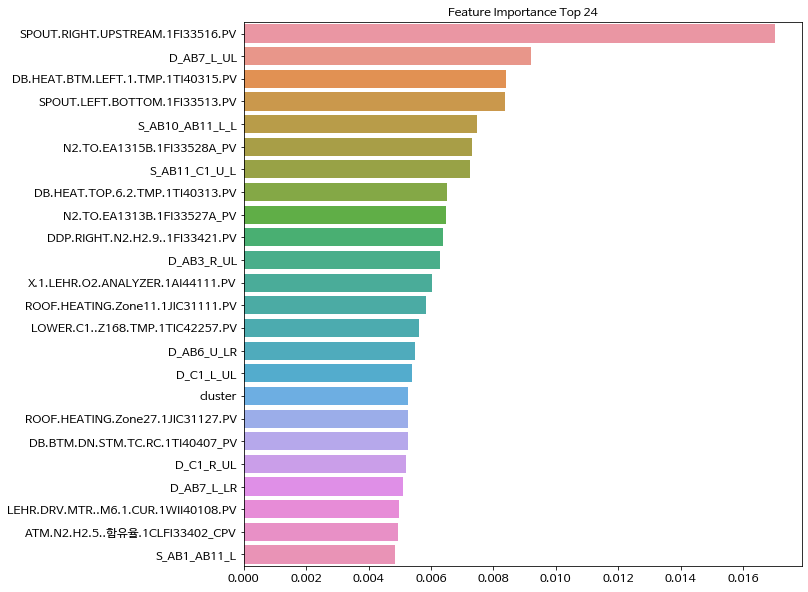

In [ ]:
ft_importance_values_10p = rf_clf_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_clf_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_10p.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_10p.dot', '-o', working_dir + '1_randomForest_LRD_10p.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

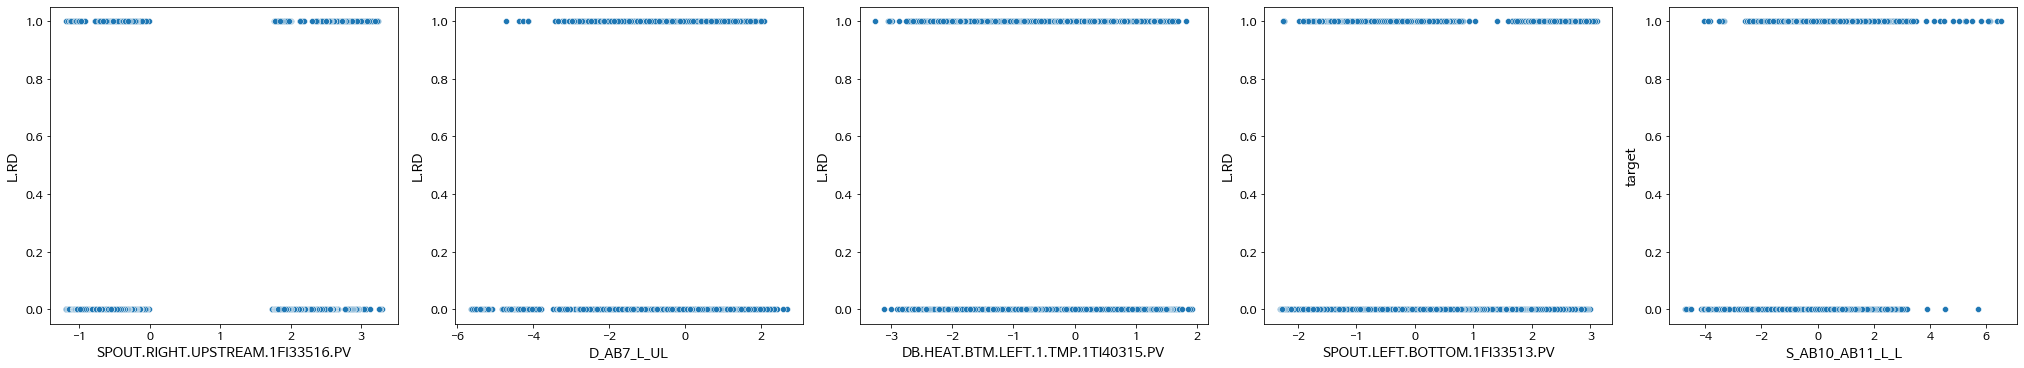

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_10p = GridSearchCV(rf_clf_10p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_10p.fit(X_train_10p, y_train_10p)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_10p = gridcv_10p.best_estimator_
# print(rf_estimator_10p)
# rf_predict_10p = rf_estimator_10p.predict(X_test_10p)
# rf_predict_proba_10p = rf_estimator_10p.predict_proba(X_test_10p)[:, 1]
# get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.9220380601596071
정밀도: 0.7419354838709677
재현율: 0.2929936305732484
F1: 0.4200913242009133
AUC: 0.8524430559401828


In [ ]:
rf_estimator_10p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_10p.fit(X_train_10p, y_train_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.033748
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.016409
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.015341
cluster                                0.010601
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.010298
SPOUT.LEFT.BOTTOM.1FI33513.PV          0.010142
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.009402
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.009299
D_C1_L_UL                              0.008755
DDP.RIGHT.N2.H2.9..1FI33421.PV         0.008680
S_AB11_C1_U_L                          0.008481
LOWER.C1..Z168.TMP.1TIC42257.PV        0.008015
D_C1_R_UL                              0.007690
D_AB7_L_UL                             0.007614
D_AB8_R_UL                             0.007363
LOWER.C2..Z182.TMP.1TIC42357.PV        0.007311
D_AB3_R_UL                             0.007213
N2.TO.EA1315B.1FI33528A_PV             0.007120
D_AB8_L_UL                             0.006254
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006207
D_AB6_U_LR                             0

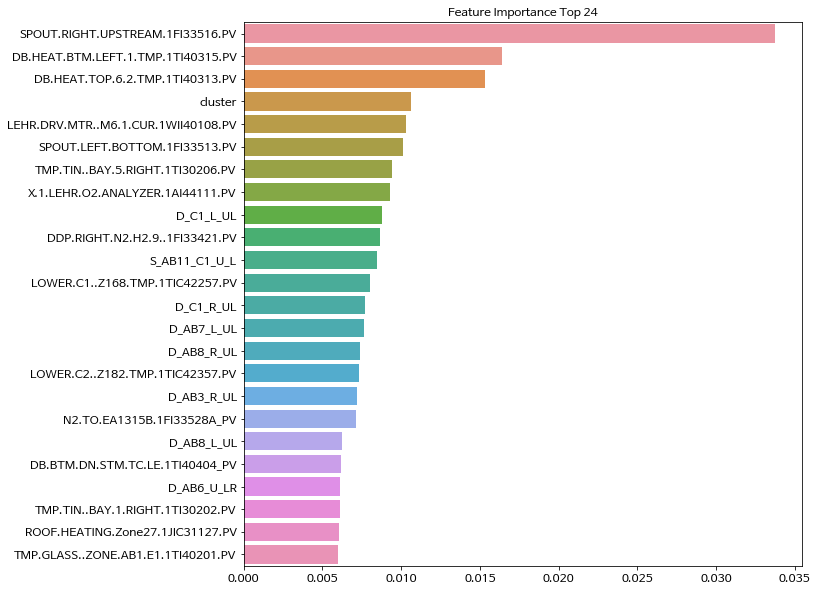

In [ ]:
ft_importance_values_10p = rf_estimator_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_estimator_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_10p.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_10p.dot', '-o', working_dir + '2_randomForest_LRD_10p.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

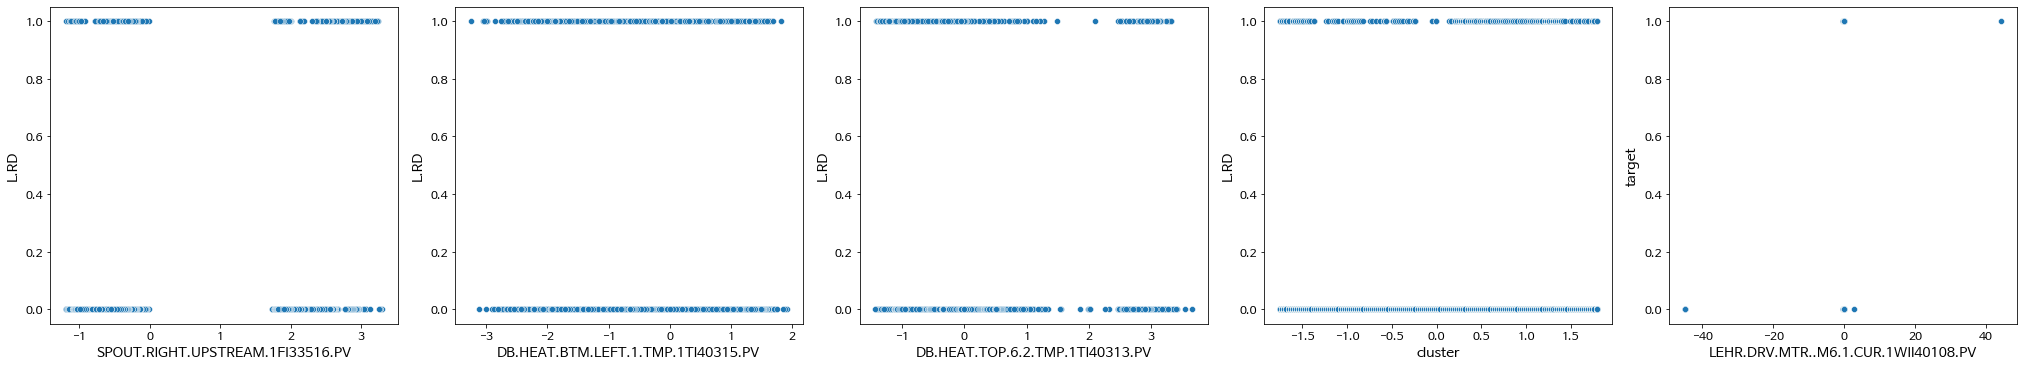

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

# 임계치: 0.01 
- 레이블에 대해 불량품(1)과 양품(0)으로 분류
- 0.01이상의 데이터는 불량품, 이외는 양품으로 Labeling을 한다.


In [ ]:
y_data_labels_001 = pd.DataFrame(np.where(y_data > 0.01, 1, 0), columns = y_data.columns)
y_data_labels_001.head()

,L.RD,L.Vac,R.RD,R.Vac
0,1,1,1,1
1,0,1,1,0
2,1,1,0,0
3,0,1,0,0
4,0,0,0,0


### 임계치가 0.01 설정의 경우, 카운트 그래프

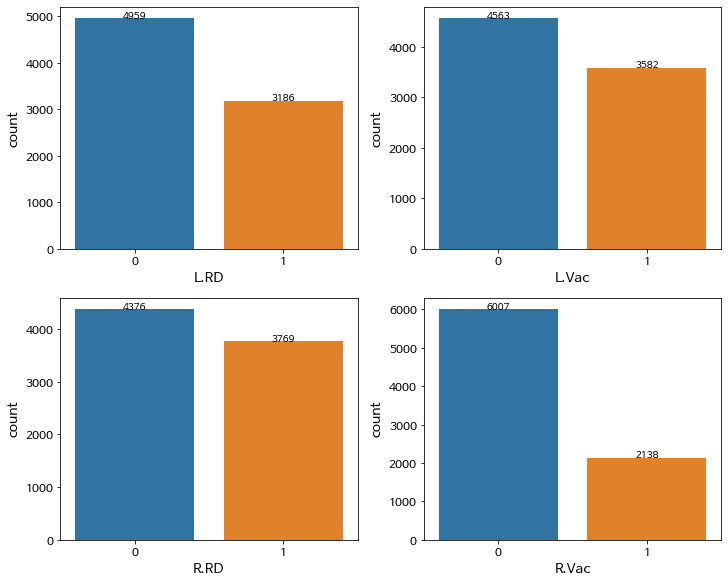

In [ ]:
show_labels_cnt(y_data_labels_001)

## 훈련데이터와 테스트데이터 분리

### L.RD

In [ ]:
X_train_001, X_test_001, y_train_001, y_test_001 = train_test_split(X_data, y_data_labels_001.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_001.shape)
print(y_test_001.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_001.value_counts()/y_train_001.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_001.value_counts()/y_test_001.count())

(6516,)
(1629,)
0    0.610804
1    0.389196
Name: L.RD, dtype: float64
0    0.600982
1    0.399018
Name: L.RD, dtype: float64


## RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_001 = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_clf_001.predict(X_test_001)
rf_predict_proba_001 = rf_clf_001.predict_proba(X_test_001)[:,1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6930632289748312
정밀도: 0.6420454545454546
재현율: 0.5215384615384615
F1: 0.5755517826825127
AUC: 0.7385173253712579


### 하이퍼파라미터 튜닝 전의 피처 중요도

S_AB11_C1_U_L                            0.008785
cluster                                  0.007251
S_AB11_C1_L_L                            0.006934
ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV    0.006346
LOWER.C1..Z168.TMP.1TIC42257.PV          0.006305
TMP.TIN..BAY.5.RIGHT.1TI30206.PV         0.005511
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV       0.005288
LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1       0.005207
TMP.TIN..BAY.1.RIGHT.1TI30202.PV         0.004861
D_C1_L_UL                                0.004859
LOWER.C3..Z193TMP.1TIC42454.PV           0.004791
ROOF.HEATING.Zone49.1JIC31149.PV         0.004591
ROOF.HEATING.Zone36.1JIC31136.PV         0.004581
UPPER.C2..Z175.TMP.1TIC42307.PV          0.004574
DB.BTM.UP.STM.TC.RE.1TI40403_PV          0.004570
S_C1_C2_U_L                              0.004454
UPPER.C1..Z155.TMP.1TIC42201.PV          0.004448
ROOF.HEATING.Zone57.1JIC31157.PV         0.004355
S_C2_C3_U_R                              0.004320
ROOF.HEATING.Zone63.1JIC31163.PV         0.004168


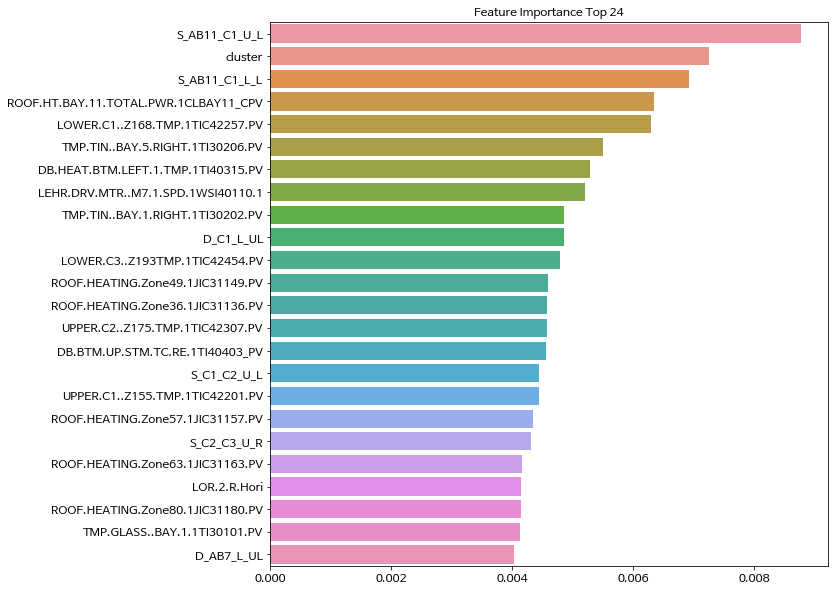

In [ ]:
ft_importance_values_001 = rf_clf_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_clf_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_001.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_001.dot', '-o', working_dir + '1_randomForest_LRD_001.png', '-Gdpi=600'])

0

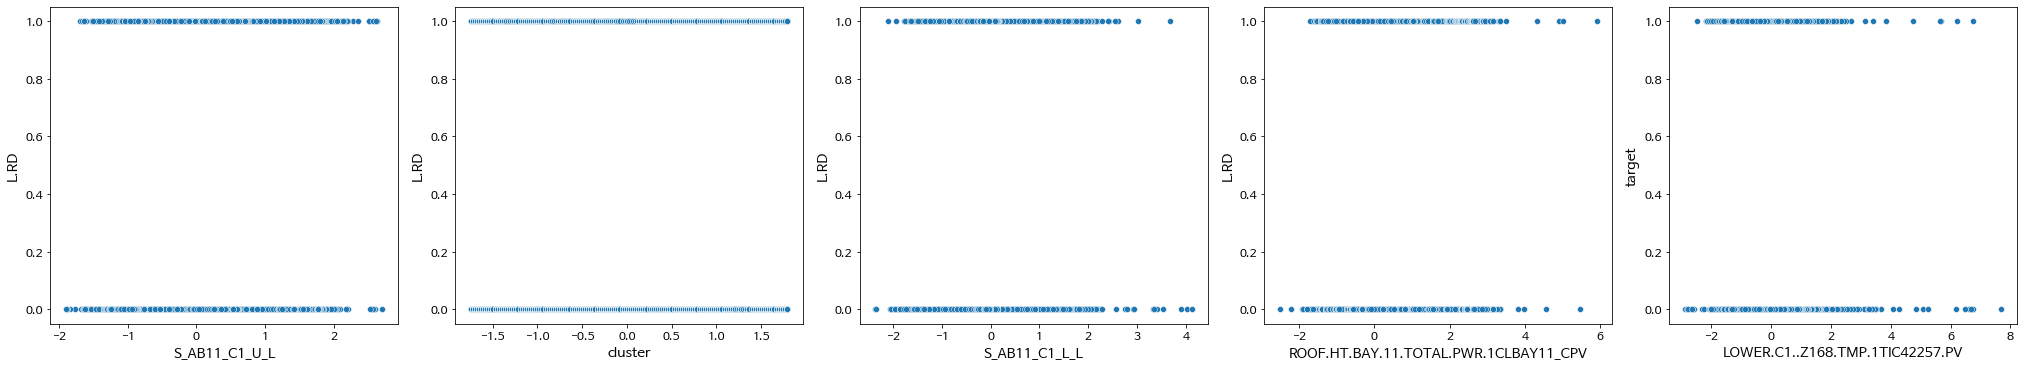

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)

## 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
# params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
#           'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# # cv를 5로 설정
# # 재현율을 높이도록 하이퍼파라미터 튜닝
# gridcv_001 = GridSearchCV(rf_clf_001, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
# gridcv_001.fit(X_train_001, y_train_001)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
# print(rf_estimator_001)
# rf_predict_001 = rf_estimator_001.predict(X_test_001)
# rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
# get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
rf_estimator_001 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_estimator_001.predict(X_test_001)
rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6924493554327809
정밀도: 0.6435452793834296
재현율: 0.5138461538461538
F1: 0.5714285714285715
AUC: 0.7359267698593541


### 하이퍼파라미터 튜닝 후의 피처 중요도

LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1     0.017240
S_AB11_C1_L_L                          0.011341
cluster                                0.009837
D_C1_L_UL                              0.009624
TMP.TIN..BAY.1.RIGHT.1TI30202.PV       0.009026
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.008697
LOWER.C1..Z168.TMP.1TIC42257.PV        0.007849
TMP.TIN..BAY.5.RIGHT.1TI30206.PV       0.007298
TMP.TIN..BAY.5.LEFT.1TI30205.PV        0.007154
SPOUT.RIGHT.UPSTREAM.1FI33516.PV       0.006775
ROOF.HEATING.Zone36.1JIC31136.PV       0.006743
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.006741
TMP.GLASS..Z_RET.E1.1TI40241.PV        0.006639
UPPER.C1..Z155.TMP.1TIC42201.PV        0.006618
TMP.GLASS..BAY.6.1TI30106.PV           0.006544
LOWER.C3..Z193TMP.1TIC42454.PV         0.006104
ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV    0.006057
DB.BTM.UP.STM.TC.RE.1TI40403_PV        0.006017
ROOF.HEATING.Zone.9.1JIC31109.PV       0.005542
l_r_tin_bay5                           0.005506
S_AB1_AB2_U_L                          0

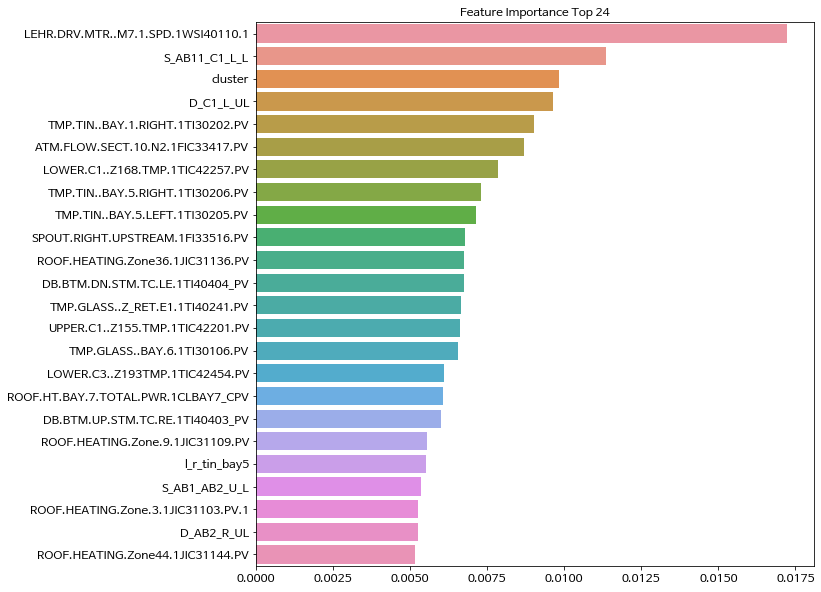

In [ ]:
ft_importance_values_001 = rf_estimator_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_estimator_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_001.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_001.dot', '-o', working_dir + '2_randomForest_LRD_001.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

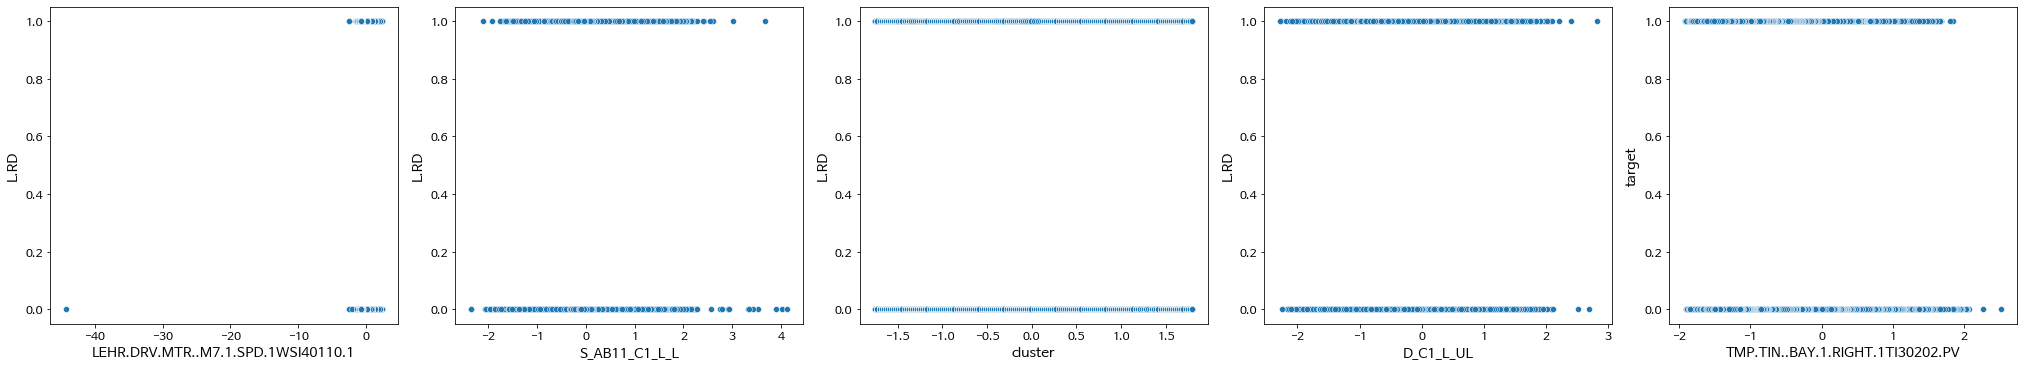

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)